[Title](encabezado_EDA.pptx)

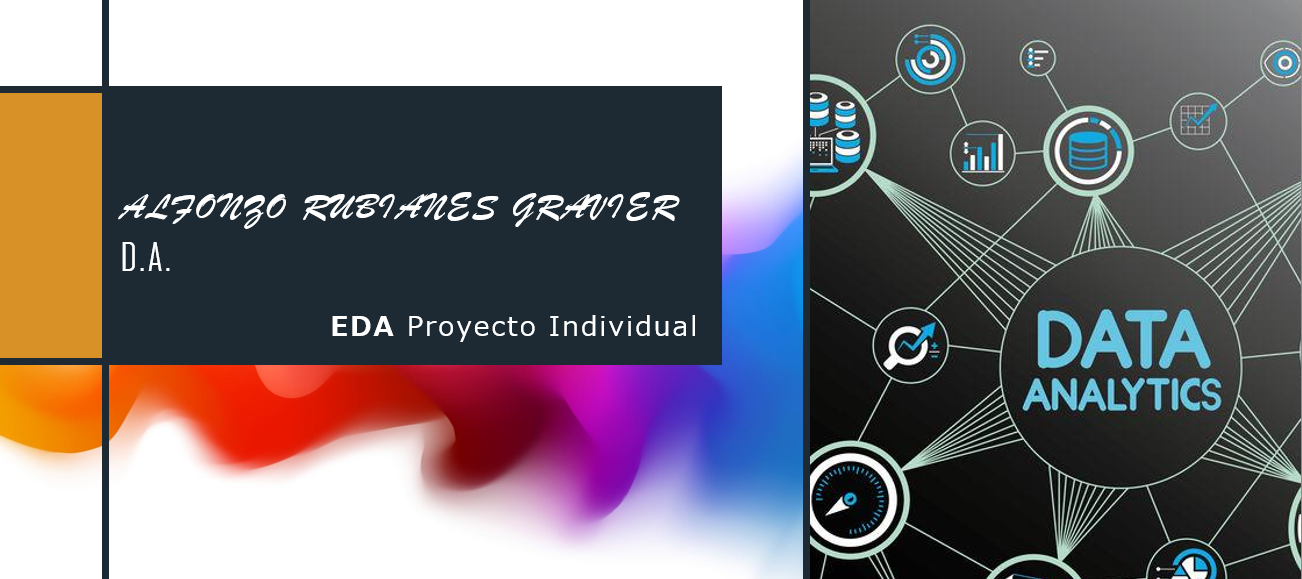

# El análisis exploratorio de datos (EDA) es un proceso utilizado por los científicos de datos para analizar y resumir conjuntos de datos. El objetivo principal del EDA es consultar los datos antes de hacer cualquier suposición. Permite identificar errores obvios, así como comprender mejor los patrones en los datos, detectar valores atípicos o sucesos anómalos y encontrar relaciones interesantes entre las variables.

# En pocas palabras, el EDA nos permitira conocer las fortalezas y vulnerabilidades del dataset con el que estamos trabajando

# Estructura del presente EDA:
1- Obtencion, Transformacion y Normalizacion de datos.
2- Visualizacion de datos.
3- Definicion del modelo predictivo.

# 1 - Obtencion, Transformacion y Normalizacion de datos.

Los datos fueron extraidos de los dastaset movies.csv y credicts.csv. 
Luego fueron transformar y normalizar mediante los procesos que se podran seguir en los archivos mvp.transformaciones.ipynb y mvp_final_transfomacion.ipynb, accesibles en el mismo repositorio donde se aloja el presente.

# 2 - Visualizacon de datos.

A continuacion, a partir de datasets mas pequeños oportunamente creados para las funciones solicitadas en las consignas (las que se pueden encontrar en el archivo mvp.funciones.ipynb), procedo a visualizar las variables mas importantes del dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import circlify


In [2]:
eda_movies = pd.read_csv('dataset_normalizado.csv')

# Al interntar armar una nube de palabras de las compañias, resulta que muchos de los registros no son str, por lo que es necesario convertirlos a este formado debido a que WordCloud solo admite cadenas de texto como entrada. Para ello se agrega la segunda linea de codigo de las dos siguientes:

In [3]:
compañias = eda_movies['compañia'].tolist()
compañias_str = "".join(map(str, compañias))

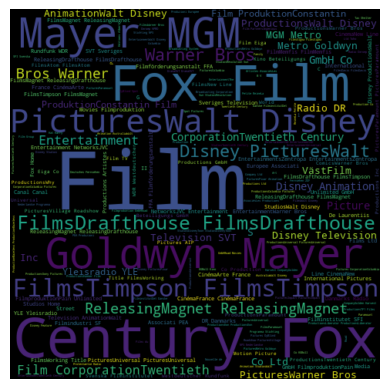

In [4]:
# Ahora que tengo un cadena de texto como entrada, genero la nube de palabras
wordcloud_compañias = WordCloud(width=480, height=480, margin=0).generate(compañias_str)
plt.imshow(wordcloud_compañias, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## De este grafico se puede observar una debilidad importante en el dataset:
Esta radica en que se observan distintas formas de llamar a una misma compañia, por ejemplo 'CenturyFox', 'Fox Film', 'Meyer', 'MGM', 'Goldwyn Meyer', etc.

# Grafico un ranking de directores a partir de los pelicula_id; es decir a partir de la cantidad de peliculas hechas.

In [12]:
df_directores = eda_movies[eda_movies['puesto'] == 'Director'].copy()
df_directores['peliculas_dirigidas'] = df_directores.groupby('crew_nombre')['pelicula_id'].transform('nunique')
df_directores = df_directores[['crew_nombre', 'peliculas_dirigidas']].drop_duplicates()

df_directores.info()
df_directores.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2668 entries, 0 to 15316
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   crew_nombre          2668 non-null   object
 1   peliculas_dirigidas  2668 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.5+ KB


,crew_nombre,peliculas_dirigidas
0,John Lasseter,4
1,Howard Deutch,3
3,Charles Shyer,2
5,Martin Campbell,4
9,Simon Wells,2


In [13]:

import squarify

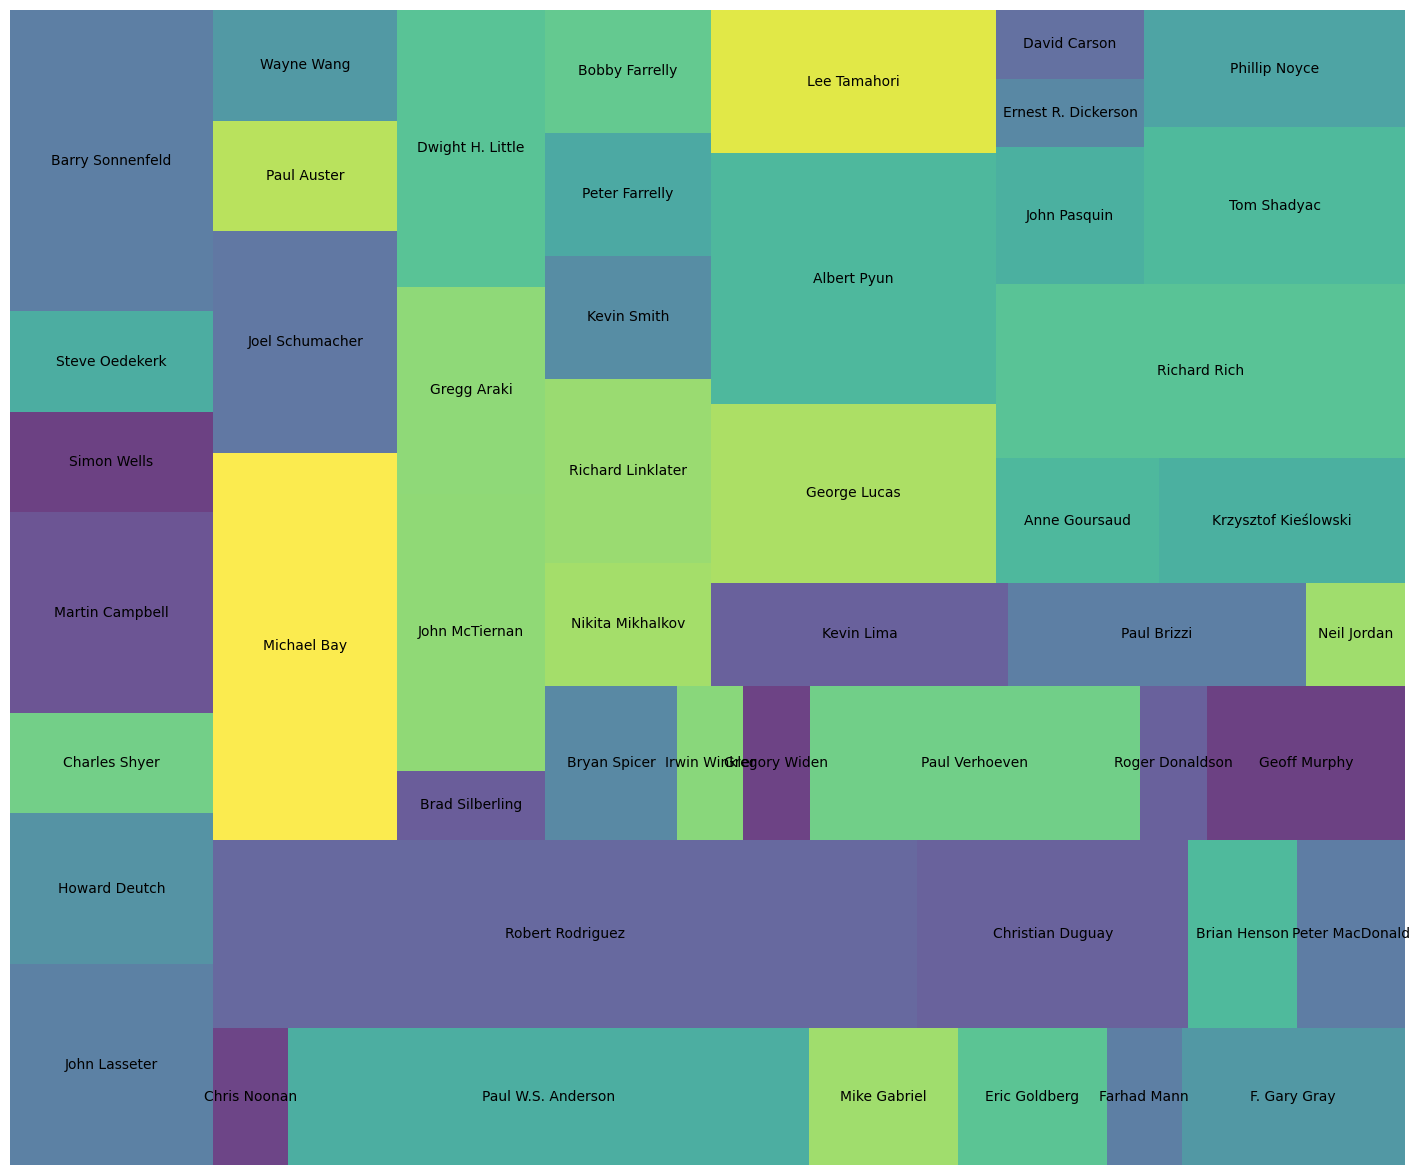

In [16]:
plt.figure(figsize=(18,15))
squarify.plot(sizes=df_directores['peliculas_dirigidas'].head(50), label=df_directores['crew_nombre'].head(50), alpha=.8 )
plt.axis('off')

plt.show()


# Aqui podemos observar un dataset bien equilibrado conciderando los directores. 

# Vamos a analisar la variable pais.

In [17]:
peliculas_por_pais = eda_movies.groupby('pais')['titulo_original'].count().reset_index(name='cantidad_peliculas')
peliculas_por_pais.head()

,pais,cantidad_peliculas
0,Afghanistan,1
1,Argentina,32
2,Australia,179
3,Austria,25
4,Bahamas,2


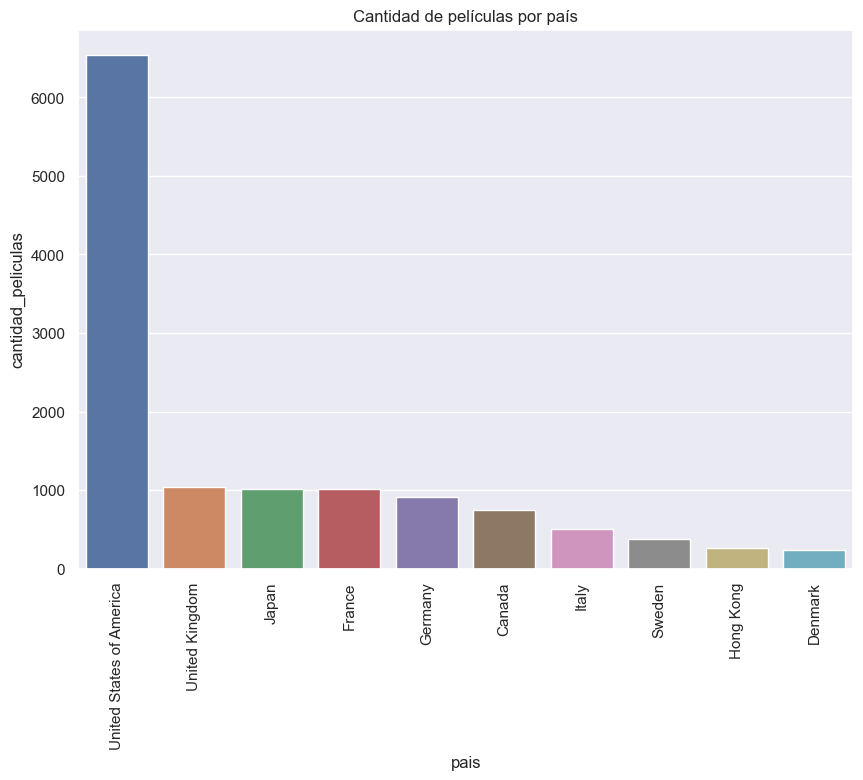

In [18]:
# definimos estilo de plot
sns.set(style="darkgrid")

# cargamos el dataset
#df = ...

# seleccionamos los 10 países con más cantidad de películas
df = peliculas_por_pais.nlargest(10, 'cantidad_peliculas')

# definimos tamaño
plt.figure(figsize=(10, 7))

# creamos el gráfico
ax = sns.barplot(x='pais', y='cantidad_peliculas', data=df)

# añadimos título
plt.title('Cantidad de películas por país')

# rotamos las etiquetas del eje x
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# mostramos el gráfico
plt.show()


## Aqui observamos una evidente relevancia de los Estados Unidos de America por sobre los demas paises en la produccion de peliculas.
Esto no es un outlier ya que en la industria cinematografica es sabida esta predominancia. Y ello nos llevara a deducir que entre los datos de idioma_original, el ingles sera, asi tambien, el mas predominante.

# Como una conclusiono final, observo mayormente inconvenientes en la falta de normalizacion en la denominacion de algunas variables. No se detecta la presencia de outliers importantes, aunque si una predominancia de algunas valores sobre otros, aunque ello resulta razonable atento a las caracteristicas que uno podria esperar en la industria cinematografica.

# Modelo predictivo

## Ahora procedemos a definir el modelo predictivo y a entrenarlo.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [22]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)
tfidf_matrix = tfidf.fit_transform(eda_movies['titulo_original'])
matriz_simil = cosine_similarity(tfidf_matrix)

svd = TruncatedSVD(n_components=100)
tfidf_svd = svd.fit_transform(tfidf_matrix)

In [24]:
def recomendacion(titulo: str):
    indice_peli = eda_movies[eda_movies['titulo_original'] == titulo].index[0]
    sim_scores = list(enumerate(matriz_simil[indice_peli]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_pelis_simil = [eda_movies.iloc[sim_score[0]]['titulo_original'] for sim_score in sim_scores[1:6]]
    return {
        'titulo': titulo,
        'recomendaciones': top_pelis_simil
    }

In [25]:
recomendacion('Toy Story')

{'titulo': 'Toy Story',
 'recomendaciones': ['Toy Story 2',
  'Toy Story 3',
  'Toy Story 3',
  'The Stig-Helmer Story',
  'A Christmas Story']}

# Por una cuestion de capacidad de memoria, he decidido, a los efectos de la recomendacion, hacerlo mediante una funcion. 
Para ello comienzo generando un dataset especifico para la misma.

In [26]:
# Creo un dataframe haciendo uso de la funcion definida anteriormente:

titulos = eda_movies['titulo_original'].unique()
recomendaciones = []

for titulo in titulos:
    recomendacion_titulo = recomendacion(titulo)
    recomendaciones.append(recomendacion_titulo['recomendaciones'])

df_recomendaciones = pd.DataFrame({'titulo_original': titulos, 'recomendaciones': recomendaciones})


In [31]:
df_recomendaciones.head()

,titulo_original,recomendaciones
0,Toy Story,"[Toy Story 2, Toy Story 3, Toy Story 3, The St..."
1,Grumpier Old Men,"[Grumpier Old Men, Grumpy Old Men, Grumpy Old ..."
2,Father of the Bride Part II,"[Father of the Bride Part II, Father of the Br..."
3,GoldenEye,"[GoldenEye, GoldenEye, GoldenEye, Toy Story, G..."
4,Balto,"[Balto, Balto, Balto II: Wolf Quest, Balto III..."


In [28]:
df_recomendaciones.to_csv('dataset_recomendaciones.csv')

# Ahora procedo a generar la funcion de recomendacion.

In [45]:
def recomendaciones(titulo):
    recomendaciones = df_recomendaciones[df_recomendaciones['titulo_original'] == titulo]['recomendaciones'].iloc[0]
    return print('Titulo:', titulo,
    '\n','Recomendaciones:', recomendaciones)


In [47]:
#Test: 

recomendaciones('Toy Story')

Titulo: Toy Story 
 Recomendaciones: ['Toy Story 2', 'Toy Story 3', 'Toy Story 3', 'The Stig-Helmer Story', 'A Christmas Story']
